## Simple audio classification model

This notebook is a simple audio classification model using tensorflow.
The model can classify 10 types of music: `Samba`, `Waltz`, `Jive`, `Rumba`, `Quickstep`, `Tango`, `ChaChaCha`, and `VienneseWaltz`. The training data is from the [ballroom](http://mtg.upf.edu/ismir2004/contest/tempoContest/node5.html) dataset.

The model is in `saved` folder.



In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2024-04-23 17:15:31.168247: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 17:15:31.216058: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 17:15:31.924051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DATASET_PATH = 'clean'

data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['Samba' 'Waltz' 'Jive' 'Rumba' 'Quickstep' 'Tango' 'ChaChaCha'
 'VienneseWaltz']


In [3]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 20693 files belonging to 8 classes.
Using 16555 files for training.
Using 4138 files for validation.


2024-04-23 17:15:33.642897: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-23 17:15:33.725274: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-23 17:15:33.725326: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-23 17:15:33.730096: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-23 17:15:33.730143: I external/local_xla/xla/stream_executor


label names: ['ChaChaCha' 'Jive' 'Quickstep' 'Rumba' 'Samba' 'Tango' 'VienneseWaltz'
 'Waltz']


In [4]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [5]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [6]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [7]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(32, 16000)
(32,)


2024-04-23 17:15:37.899043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
label_names[[1,1,3,0]]

array(['Jive', 'Jive', 'Rumba', 'ChaChaCha'], dtype='<U13')

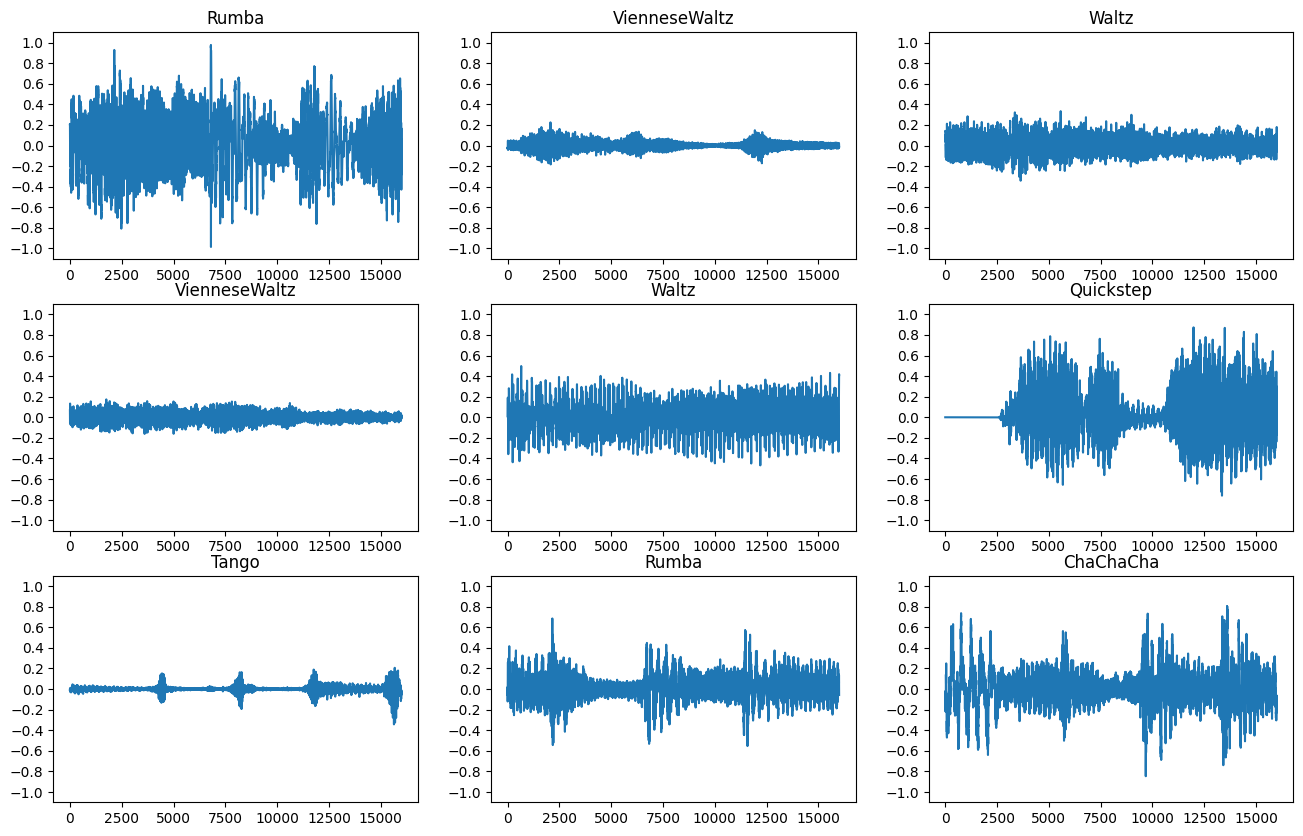

In [9]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [10]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [11]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: Rumba
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: VienneseWaltz
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: Waltz
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [12]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

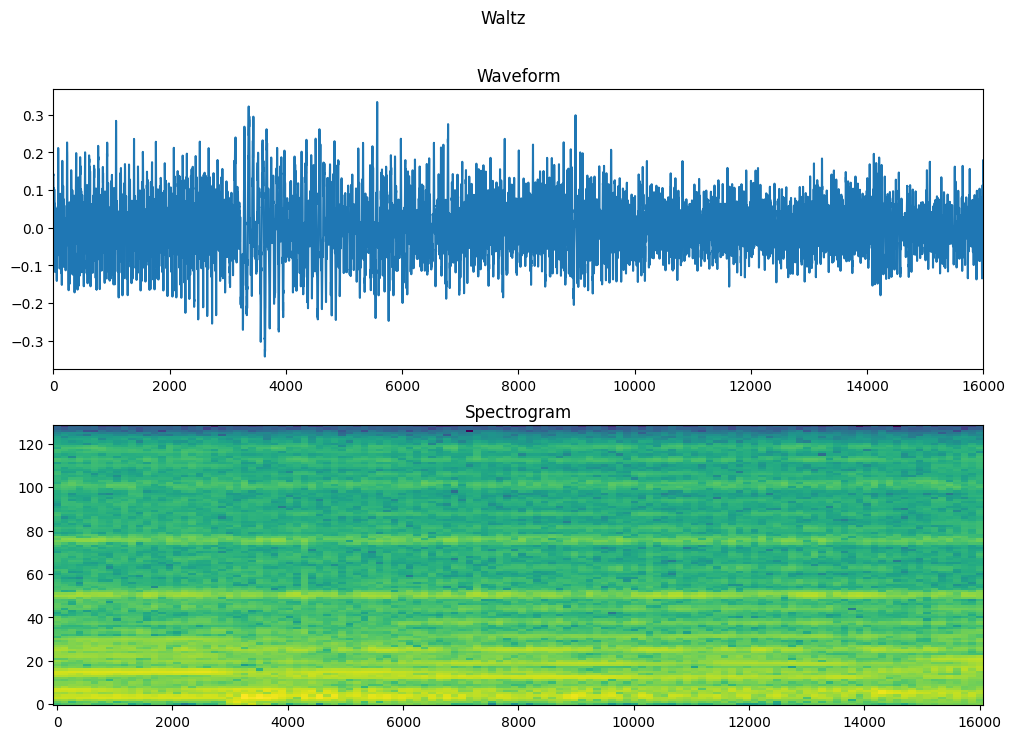

In [13]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [14]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [16]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

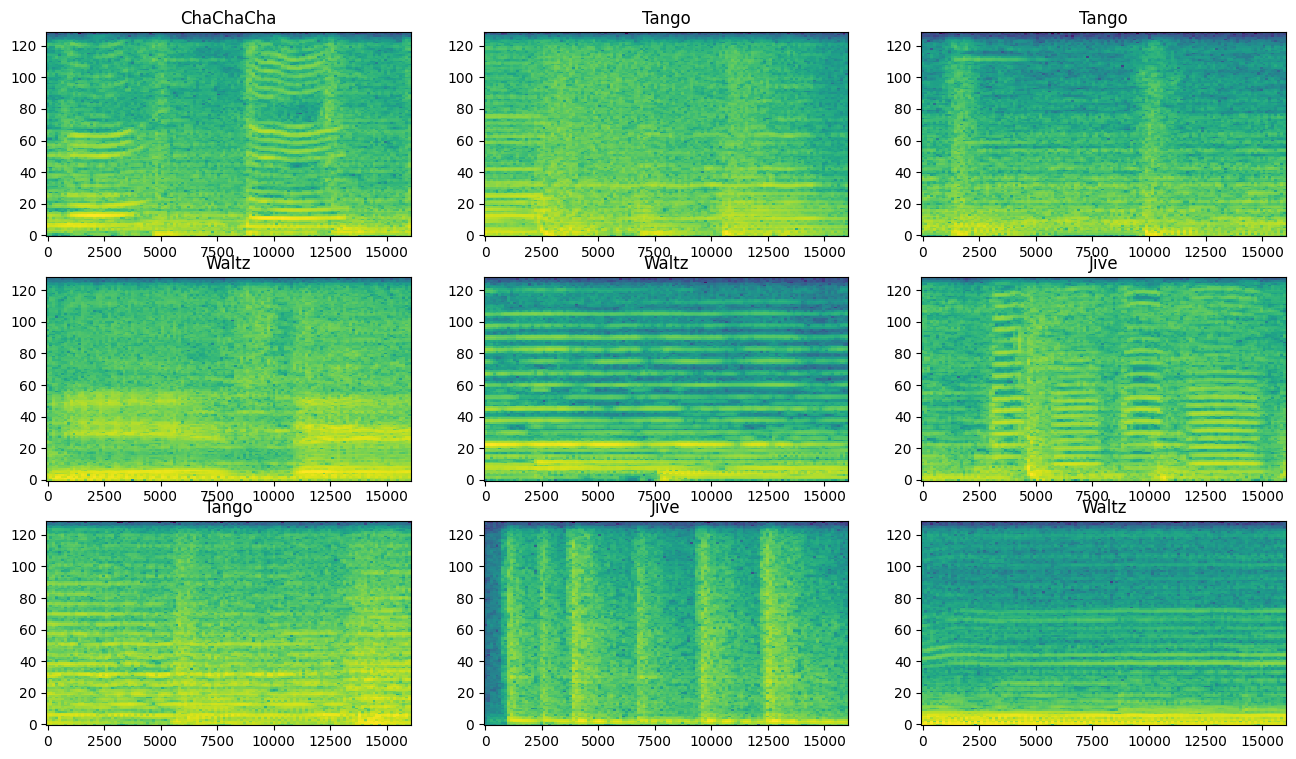

In [17]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [18]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [19]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(64, 3, padding='same', activation='relu'),  # Increased filters
    layers.Conv2D(64, 3, padding='same', activation='relu'),  # Additional conv layer
    layers.MaxPooling2D(2, 2),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),  # Additional conv layer
    layers.MaxPooling2D(2, 2),
    layers.BatchNormalization(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),  # Increased filters
    layers.Conv2D(256, 3, padding='same', activation='relu'),  # Additional conv layer
    layers.MaxPooling2D(2, 2),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),  # Increased units
    layers.Dropout(0.25),  # Increased dropout rate
    layers.Dense(num_labels, activation='softmax'),
])

model.summary()

Input shape: (124, 129, 1)


2024-04-23 17:15:43.285039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,196,939 (8.38 MB)

 Trainable params: 2,196,040 (8.38 MB)

 Non-trainable params: 899 (3.52 KB)

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)



In [21]:
EPOCHS = 30
BATCH_SIZE=32
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)



Epoch 1/30


/home/dell-shou/miniconda3/envs/xai_310/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:625: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1713881745.143807  402944 service.cc:145] XLA service 0x7f2648002b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713881745.143952  402944 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-04-23 17:15:45.205485: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-23 17:15:45.481781: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 22/518 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1892 - loss: 3.3533

I0000 00:00:1713881750.198574  402944 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


518/518 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.3433 - loss: 1.8549 - val_accuracy: 0.3576 - val_loss: 1.8547
Epoch 2/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5988 - loss: 1.1003 - val_accuracy: 0.6375 - val_loss: 1.0612
Epoch 3/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6932 - loss: 0.8692 - val_accuracy: 0.7133 - val_loss: 0.8220
Epoch 4/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7410 - loss: 0.7350 - val_accuracy: 0.6696 - val_loss: 0.9469
Epoch 5/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7765 - loss: 0.6381 - val_accuracy: 0.7415 - val_loss: 0.7145
Epoch 6/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8013 - loss: 0.5621 - val_accuracy: 0.7473 - val_loss: 0.7335
Epoch 7/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8340 - loss: 0.4715 - val_accuracy: 0.7668 - val_loss: 0.7316
Epoch 7: early stopping


Text(0, 0.5, 'Accuracy [%]')

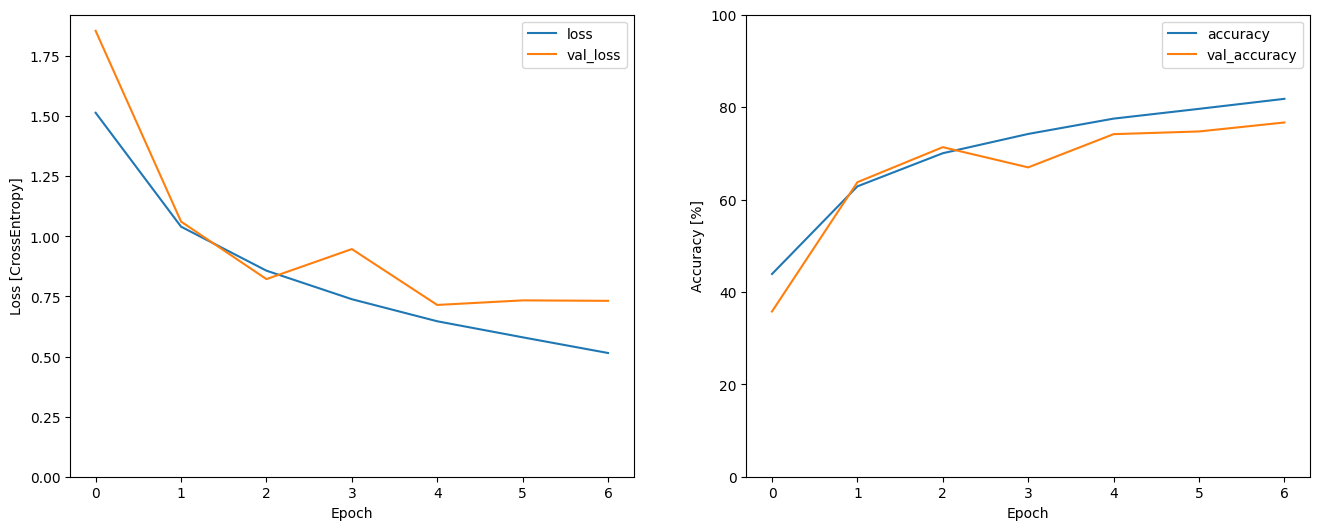

In [22]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [23]:
model.evaluate(test_spectrogram_ds, return_dict=True)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7565 - loss: 0.8021


{'accuracy': 0.7721154093742371, 'loss': 0.7659132480621338}

In [24]:
y_pred = model.predict(test_spectrogram_ds)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [25]:
y_pred = tf.argmax(y_pred, axis=1)

In [26]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

2024-04-23 17:16:27.054504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


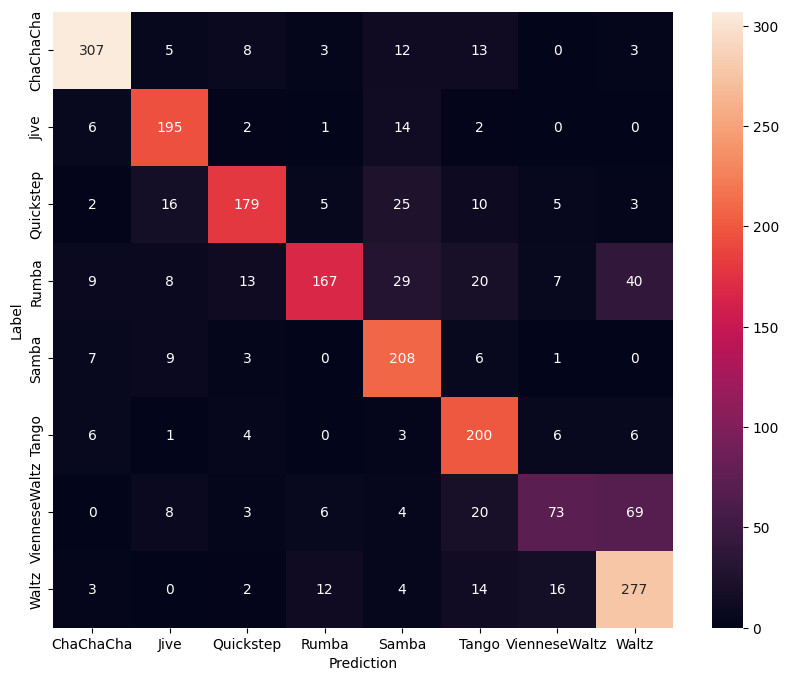

In [27]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

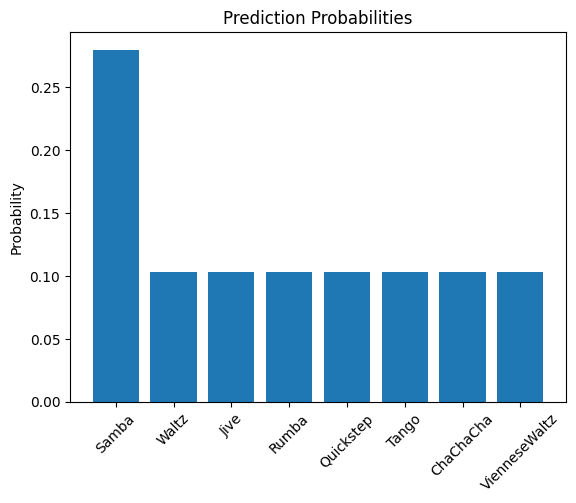

In [49]:
x = data_dir/'ChaChaCha/Albums-Cafe_Paradiso-05_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)

# Assuming `x_labels` is the list of class names corresponding to the model's outputs
x_labels = ['Samba', 'Waltz', 'Jive', 'Rumba', 'Quickstep', 'Tango', 'ChaChaCha', 'VienneseWaltz']

# Apply softmax to convert logits to probabilities
probabilities = tf.nn.softmax(prediction[0])

# Plotting the probabilities for each class
plt.bar(x_labels, probabilities.numpy())
plt.title('Prediction Probabilities')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.show()

# Display the audio file
display.display(display.Audio(waveform, rate=16000))

In [29]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # You could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))

  @tf.function(input_signature=[tf.TensorSpec(shape=(), dtype=tf.string)])
  def serve_string_input(self, x):
    x = tf.io.read_file(x)
    x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000)
    x = tf.squeeze(x, axis=-1)
    x = x[tf.newaxis, :]
    return self.__call__(x)

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, 16000], dtype=tf.float32)])
  def serve_waveform_input(self, x):
    return self.__call__(x)

  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)  
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions': result,
            'class_ids': class_ids,
            'class_names': class_names}

  # Define the serving default to handle string inputs
  @tf.function(input_signature=[tf.TensorSpec(shape=(), dtype=tf.string)])
  def serving_default(self, x):
    return self.serve_string_input(x)

In [30]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'ChaChaCha/Albums-Cafe_Paradiso-05_0.wav')))



{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[9.9982291e-01, 9.3514282e-06, 4.2100368e-08, 5.4280804e-08,
         1.6731780e-04, 4.0174351e-07, 5.8212805e-12, 5.2033638e-12]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'ChaChaCha'], dtype=object)>}

In [53]:
x = 'audio/augments/wav/ChaChaCha/Albums-Cafe_Paradiso-05_110.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x

tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
predictions = imported(waveform[tf.newaxis, :])['predictions']

tf.nn.softmax(predictions, axis=-1).numpy()



INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


array([[0.27825   , 0.10308201, 0.10301724, 0.10301962, 0.10330836,
        0.10329533, 0.10301369, 0.10301372]], dtype=float32)